Instructions for setting up conda kernel on NCAR machine:  
- open terminal (e.g., in JupyterHub)
- execute the following series of commands:

`module load conda`  
`conda create -n shap`  
`conda activate shap`  
`conda install shap pandas scikit-learn matplotlib numpy ipykernel jupyter ipywidgets`  

- now you should see a [conda-env:shap] conda kernel available when you open a jupyter notebook

In [202]:
import pandas as pd
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import shap
import seaborn as sns

# Data processing

In [2]:
# load data
filepath = '/glade/work/psturm/ice-mp-su24/saved_trajectory_data/trajs_5100_7200_Ns10000.csv' # obin's latest csv with combined data
df = pd.read_csv(filepath)
# sort df
sort_cols = ['time', 'rk_deact']
df_sort = df.sort_values(by=sort_cols)
# # print time and rk_deact columns as quick check
# print(df_sort[sort_cols])
# # do a check for a single timestep
# df_5100 = df_sort[df_sort.time==5100]
# print('Check for single timestep 5100s')
# print(f'length of ID vector: {len(df_5100.rk_deact)}')
# print(f'number of unique IDs: {len(df_5100.rk_deact.unique())}')
# calculate mass and add as column
df_sort['volume[m3]'] = (4/3)*np.pi*(df_sort['radius_eq(ice)[m]'])**3
df_sort['mass[kg]'] = df_sort['volume[m3]']*df_sort['density(droplet/ice)[kg/m3]']
# df of current timestep
df1 = df_sort 
n_unique_ids = len(df1['rk_deact'].unique())
len_df = len(df1) - n_unique_ids
df1 = df_sort[:len_df]
df1.reset_index(inplace=True)
# df of next timestep
df2 = df_sort
df2 = df2[n_unique_ids:]
df2.reset_index(inplace=True)
# join dataframes
df = df1.join(df2, lsuffix='_1', rsuffix='_2')
df['delta_mass'] = df['mass[kg]_2'] - df['mass[kg]_1'] # add change in mass
df['delta_r'] = df['radius_eq(ice)[m]_2'] - df['radius_eq(ice)[m]_1'] # add change in radius
# split into training and test data
ids = df['rk_deact_1'].unique()
ids_train, ids_test = train_test_split(ids, test_size=0.2, random_state=666)
df_train = df[df['rk_deact_1'].isin(ids_train)]
df_test = df[df['rk_deact_1'].isin(ids_test)]

# Predicting Mass

## Linear Regression

In [ ]:
df_train.columns

In [ ]:
# train model and predict
model = linear_model.LinearRegression()
X_cols = ['RH_ice_1', 'mass[kg]_1']
y_cols = ['mass[kg]_2']
X_train = df_train[X_cols]
y_train = df_train[y_cols]
X_test = df_test[X_cols]
y_test = df_test[y_cols]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [ ]:
df_train.columns

In [ ]:
# plot mass growth vs. RH_ice relationship
df_train['mass_diff']=df_train['mass[kg]_2'] - df_train['mass[kg]_1']
plt.scatter(df_train['mass_diff'], df_train['RH_ice_1'], color="black")

In [ ]:
# plot results

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(y_pred, y_test, color="black")
# plt.plot(X_test, y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.show()

### multi-step prediction with single-timestep linear model

i.e., what happens if we predict mass change in a markov chain fashion over multiple time steps into the future?

## Random forest

In [ ]:
# get subset for faster training (if needed)
X_train_subset = X_train.sample(50000)
train_idx = X_train_subset.index
y_train_subset = y_train.loc[train_idx]
print(X_train_subset.shape)
print(y_train_subset.shape)

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=666, max_depth=50, 
                           bootstrap=True, criterion='poisson')
# rf.fit(X_train, y_train.values.ravel())
rf.fit(X_train_subset, y_train_subset.values.ravel())
y_pred_rf = rf.predict(X_test)
len(np.unique(y_pred_rf))

In [ ]:
# plot results

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_rf))

# Plot outputs
plt.scatter(y_pred_rf, y_test, color="black")
# plt.plot(X_test, y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.show()

Notes on RF:  
- seems to be quite sensitive to hyperparameters
- squared_error and friendmas_mse returns a single value
- poisson and absolute_error return different values
- absolute_error is very slow
- seems to do much worse than linear regression

## Neural Network

In [ ]:
# # get subset for faster training (if needed)
# X_train_subset = X_train.sample(50000)
# train_idx = X_train_subset.index
# y_train_subset = y_train.loc[train_idx]
# print(X_train_subset.shape)
# print(y_train_subset.shape)

In [ ]:
# fit mlp and predict
mlp = MLPRegressor(random_state=666, max_iter=500, 
                   hidden_layer_sizes=(100))
# mlp.fit(X_train, y_train.values.ravel())
# y_pred_mlp = mlp.predict(X_test)
y_scaler = StandardScaler().fit(y_train.values)
pipe = make_pipeline(StandardScaler(), mlp)
# pipe.fit(X_train, y_train.values.ravel())
pipe.fit(X_train, y_scaler.transform(y_train.values).ravel())
y_pred_mlp_scaled = pipe.predict(X_test)
y_pred_mlp = y_scaler.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1))

In [ ]:
# plot results

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_mlp))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_mlp))

# Plot outputs
fig, ax = plt.subplots()
plt.scatter(y_pred_mlp, y_test, color="blue", alpha=0.8)
ax.set_box_aspect(1)
plt.show()

# Predicting CHANGE in Mass

In [38]:
# set up data
X_cols = ['RH_ice_1', 'mass[kg]_1', 'radius_eq(ice)[m]_1', 'density(droplet/ice)[kg/m3]_1',
         'rhod [kg/m3]_1', 'prs_1', 'qv_1', 'T [K]_1']
y_cols = ['delta_mass']
X_train = df_train[X_cols]
y_train = df_train[y_cols]
X_test = df_test[X_cols]
y_test = df_test[y_cols]
# remove suffix from column names
X_train.columns = X_train.columns.str.replace('_1', '')
X_test.columns = X_test.columns.str.replace('_1', '')

## Neural Network

In [39]:
# Standardize data
y_scaler = StandardScaler().set_output(transform='pandas').fit(y_train)
X_scaler = StandardScaler().set_output(transform='pandas').fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

In [40]:
# fit mlp and predict
mlp = MLPRegressor(random_state=666, max_iter=100, 
                   hidden_layer_sizes=(100),
                   verbose=1)
mlp.fit(X_train_scaled, y_train_scaled.values.ravel())
y_pred_mlp_scaled = mlp.predict(X_test_scaled)
y_pred_mlp = y_scaler.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1))

Iteration 1, loss = 0.05393727
Iteration 2, loss = 0.03151542
Iteration 3, loss = 0.03088242
Iteration 4, loss = 0.03027022
Iteration 5, loss = 0.03015567
Iteration 6, loss = 0.03008841
Iteration 7, loss = 0.02966709
Iteration 8, loss = 0.02985295
Iteration 9, loss = 0.02970214
Iteration 10, loss = 0.02971344
Iteration 11, loss = 0.02971930
Iteration 12, loss = 0.02948467
Iteration 13, loss = 0.02952976
Iteration 14, loss = 0.02941534
Iteration 15, loss = 0.02926299
Iteration 16, loss = 0.02943855
Iteration 17, loss = 0.02926784
Iteration 18, loss = 0.02928423
Iteration 19, loss = 0.02916028
Iteration 20, loss = 0.02920794
Iteration 21, loss = 0.02915778
Iteration 22, loss = 0.02926119
Iteration 23, loss = 0.02922563
Iteration 24, loss = 0.02907692
Iteration 25, loss = 0.02905086
Iteration 26, loss = 0.02913694
Iteration 27, loss = 0.02891369
Iteration 28, loss = 0.02894337
Iteration 29, loss = 0.02895524
Iteration 30, loss = 0.02887031
Iteration 31, loss = 0.02908608
Iteration 32, los

Mean squared error: 7.24E-23
Coefficient of determination: 0.95


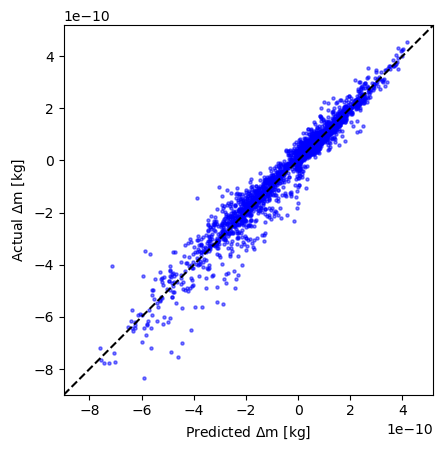

In [41]:
# Plot results
# The mean squared error
print("Mean squared error: %.2E" % mean_squared_error(y_test, y_pred_mlp))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_mlp))
fig, ax = plt.subplots()
plt.scatter(y_pred_mlp, y_test, color="blue", alpha=0.5, s=5.0)
ax.axline((0, 0), slope=1, color='black', linestyle='--')
ax.set_aspect('equal', adjustable='box')
plt.xlim(ax.get_ylim()) # set x/y axes limits
plt.xlabel(r'Predicted $\Delta$m [kg]')
plt.ylabel(r'Actual $\Delta$m [kg]')
plt.show()

### SHAP Analysis for NN

  0%|          | 0/5000 [00:00<?, ?it/s]

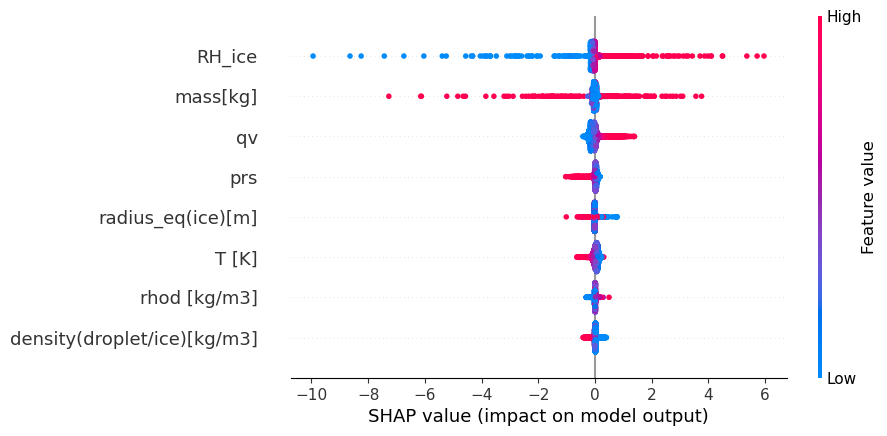

CPU times: user 4min 26s, sys: 507 ms, total: 4min 27s
Wall time: 4min 47s


In [59]:
%%time
# SHAP analysis
n_shap_samples = 5000
n_background = 50
n_clusters = 5
# background = shap.kmeans(X_train_scaled, n_clusters) # can use this as background for larger datasets
background = X_train_scaled.sample(n_background) # background dataset (https://stackoverflow.com/questions/72309555/purpose-of-background-dataset-for-shap-library-deep-explainer)
explainer = shap.KernelExplainer(mlp.predict, X_train_scaled.sample(50))
shap_values = explainer(X_test_scaled.sample(n_shap_samples))
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0)) # beeswarm plot

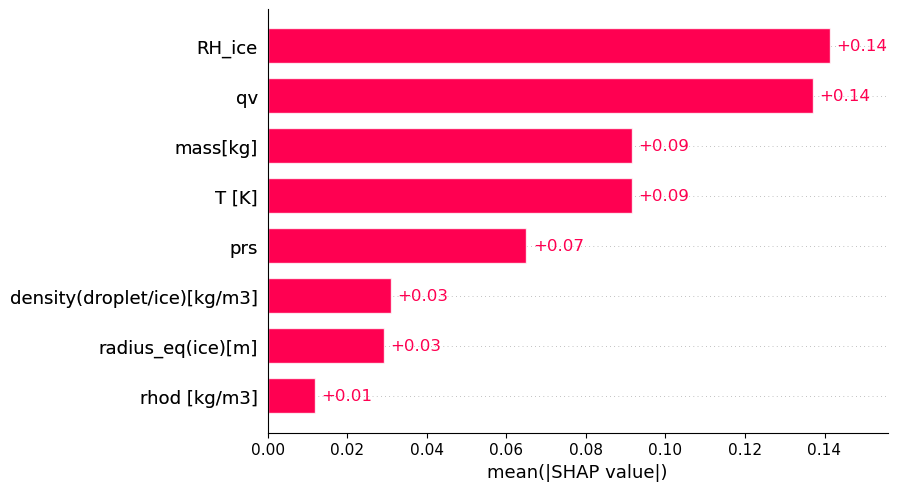

In [61]:
# plot absolute mean shap values as bar plot
shap.plots.bar(shap_values.abs.mean(0))

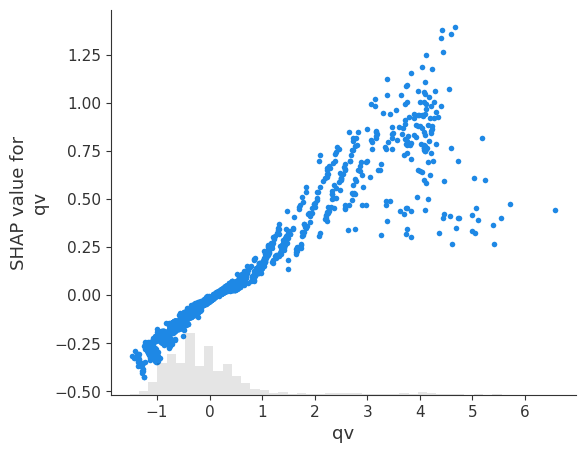

In [68]:
# dependence scatter plot for single feature, qv
shap.plots.scatter(shap_values[:, 'qv'])

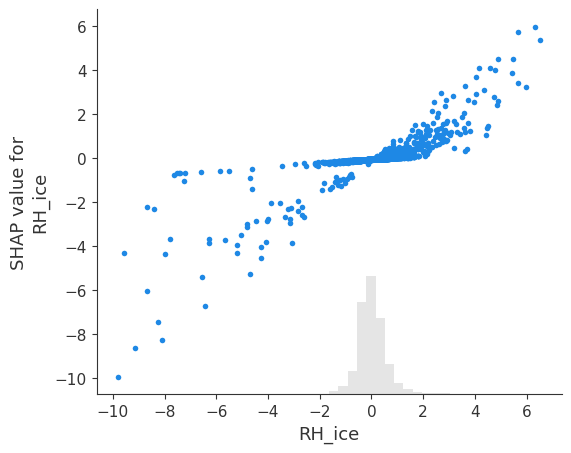

In [69]:
# dependence scatter plot for single feature, RH_ice
shap.plots.scatter(shap_values[:, 'RH_ice'])

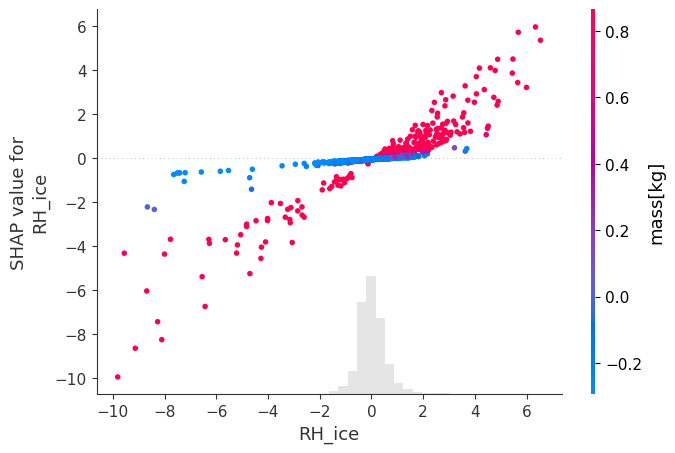

In [81]:
# dependence scatter plot for single feature, RH_ice + color to highlight dominant interaction term
shap.plots.scatter(shap_values[:, 'RH_ice'], color=shap_values)